In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD


In [ ]:
import tensorflow as tf

class CustomActivation(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomActivation, self).__init__()
        self.k0 = self.add_weight(name="k0", initializer="random_normal", trainable=True)
        self.k1 = self.add_weight(name="k1", initializer="random_normal", trainable=True)

    def call(self, inputs):
        return self.k0 + self.k1 * tf.square(inputs)


In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load dataset
data = load_iris()
X = data.data
y = data.target.reshape(-1, 1)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)


In [ ]:
def create_model(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, input_dim=input_dim),
        CustomActivation(),
        tf.keras.layers.Dense(output_dim, activation="softmax")  # Output layer for classification
    ])
    return model

# Initialize model
model = create_model(input_dim=X_train.shape[1], output_dim=y_train.shape[1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=8)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.3056 - loss: 1.1052 - val_accuracy: 0.3000 - val_loss: 1.1027
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3201 - loss: 1.1014 - val_accuracy: 0.3000 - val_loss: 1.1002
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3743 - loss: 1.0928 - val_accuracy: 0.3000 - val_loss: 1.0936
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4057 - loss: 1.0828 - val_accuracy: 0.5667 - val_loss: 1.0800
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6203 - loss: 1.0730 - val_accuracy: 0.7667 - val_loss: 1.0558
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8190 - loss: 1.0460 - val_accuracy: 0.8000 - val_loss: 1.0186
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8287 - loss: 0.9885 - val_accuracy: 0.7667 - val_loss: 0.9609
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7605 - loss: 0.9352 - val_accuracy: 0.7667 - val_loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



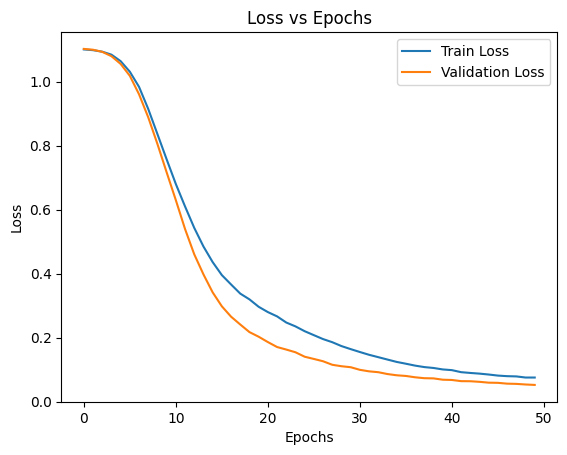

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Evaluate
y_pred = model.predict(X_test)
y_pred_labels = tf.argmax(y_pred, axis=1).numpy()
y_true_labels = tf.argmax(y_test, axis=1).numpy()

# Classification report
print(classification_report(y_true_labels, y_pred_labels))

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()


In [ ]:
!pip install fastapi uvicorn nest_asyncio tensorflow numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.7 MB/s eta 0:00:00


In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import nest_asyncio
from fastapi.responses import JSONResponse

# Enable nested event loops for Jupyter Notebook
nest_asyncio.apply()

# Create the FastAPI app
app = FastAPI()

# Define input schema
class PredictionInput(BaseModel):
    features: list

# Root endpoint
@app.get("/")
def read_root():
    return {"message": "Welcome to the Neural Network API"}

# Prediction endpoint
@app.post("/predict/")
def predict(input_data: PredictionInput):
    try:
        # Convert input data to NumPy array
        input_array = np.array(input_data.features).reshape(1, -1)

        # Predict using the trained model
        predictions = model.predict(input_array)
        predicted_class = int(np.argmax(predictions, axis=1)[0])
        probabilities = predictions.tolist()

        return JSONResponse(content={
            "predicted_class": predicted_class,
            "probabilities": probabilities
        })
    except Exception as e:
        return JSONResponse(content={"error": str(e)}, status_code=400)


In [ ]:
import uvicorn

# Start the FastAPI server
uvicorn.run(app, host="127.0.0.1", port=8000)


INFO:     Started server process [223]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


In [ ]:
import requests

# Test the prediction endpoint
url = "http://127.0.0.1:8000/predict/"
input_data = {
    "features": [5.1, 3.5, 1.4, 0.2]  # Example input data
}

response = requests.post(url, json=input_data)
print("Response:", response.json())


ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=8000): Max retries exceeded with url: /predict/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7b1ab070a7d0>: Failed to establish a new connection: [Errno 111] Connection refused'))